In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

# About dataset

This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

Field	          Description
Loan_status	      Whether a loan is paid off on in collection
Principal	      Basic principal loan amount at the
Terms	          Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule
Effective_date	  When the loan got originated and took effects
Due_date	      Since it’s one-time payoff schedule, each loan has one single due date
Age	              Age of applicant
Education	      Education of applicant
Gender	          The gender of applicant


Lets download the dataset


# Load Data From CSV File

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-04-16 23:00:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2021-04-16 23:00:58 (1.77 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
df.shape

(346, 10)

# Convert to date time object

In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Let’s see how many of each class is in our data set

In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Lets plot some columns to underestand data better:

In [ ]:
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


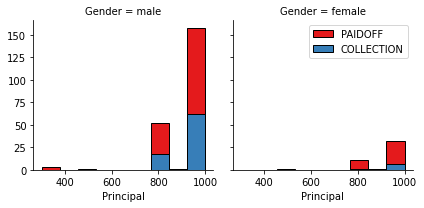

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

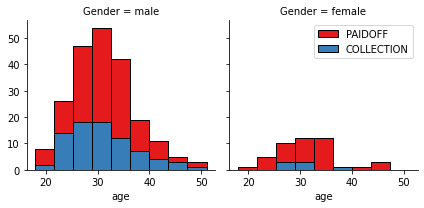

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction


Lets look at the day of the week people get the loan

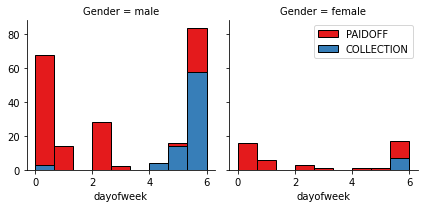

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Convert Categorical features to numerical values

Lets look at gender:

In [ ]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [ ]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


# One Hot Encoding

How about education?

In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

# Feature befor One Hot Encoding

In [ ]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Feature selection

Lets defind feature sets, X:

In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [ ]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model You should use the following algorithm:

K Nearest Neighbor(KNN)
Decision Tree
Support Vector Machine
Logistic Regression
Notice:

You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.
warning: You should not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.


In [ ]:
#Splitting dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape,y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


[0.67142857 0.65714286 0.71428571 0.68571429 0.75714286 0.71428571
 0.78571429 0.75714286 0.75714286]


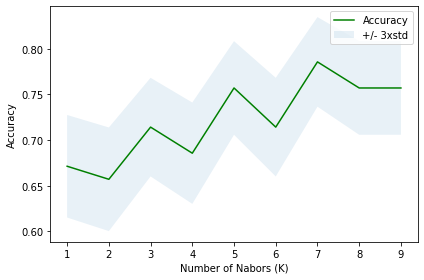

The best Acuuracy was with 0.7857142857142857 with k= 7


In [ ]:
#import library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test,yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

#accuracy
print(mean_acc)

#plot model accuracy for Differnt number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc -1 * std_acc,mean_acc + 1 * std_acc,alpha=0.10)
plt.legend(('Accuracy', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

#result
print("The best Acuuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)


In [ ]:
#trian model k=7
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

# Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#Training
loanTree.fit(X_train,y_train)
loanTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Support Vector machine

In [ ]:
#import library
from sklearn import svm

In [ ]:

#training
clf = svm.SVC()

In [ ]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Logistic Regression

In [ ]:
#import library
from sklearn.linear_model import LogisticRegression

In [ ]:
#training
LR = LogisticRegression(C=0.01).fit(X_train,y_train)

In [ ]:
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluating  using Test set

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-16 23:07:53--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-16 23:07:53 (891 MB/s) - ‘loan_test.csv’ saved [3642/3642]



Load Test set for Evaluation

In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
test_df.shape

(54, 10)

In [ ]:
#Pre-processing loan_test
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

test_X = Feature_test

test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -4.12310563,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -4.12310563,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -4.12310563,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.24253563,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.24253563,
         2.39791576, -0.79772404, -0.86135677]])

In [ ]:
#Pre-processing loan_test
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
#predicted y
yhat_knn = neigh.predict(test_X)

#jaccard
jaccard_knn = jaccard_score(test_y,yhat_knn,pos_label = "PAIDOFF")
print("KNN Jaccard index:", jaccard_knn)

#f1_score
f1_score_knn = f1_score(test_y,yhat_knn, average='weighted')
print("KNN F1-score:", f1_score_knn)

KNN Jaccard index: 0.6730769230769231
KNN F1-score: 0.6453810131971051


In [ ]:
#Decision Tree
#Predicted y
yhat_dt = loanTree.predict(test_X)

#jaccard
jaccard_dt = jaccard_score(test_y,yhat_dt, pos_label = "PAIDOFF")
print("DT JAccard index:", jaccard_dt)

#f1_score
f1_score_dt = f1_score(test_y,yhat_dt, average='weighted')
print("DT F1-score:", f1_score_dt)

DT JAccard index: 0.3953488372093023
DT F1-score: 0.5385802469135802


In [ ]:
#Support Vector machine
#predicted y
yhat_svm = clf.predict(test_X)

#jaccard
jaccard_svm = jaccard_score(test_y, yhat_svm,pos_label = "PAIDOFF")
print("SVM Jaccard index:", jaccard_svm)

#f1-score
f1_score_svm = f1_score(test_y, yhat_svm, average='weighted')
print("SVM F1-score:", f1_score_svm)


SVM Jaccard index: 0.7959183673469388
SVM F1-score: 0.7861952861952862


In [ ]:
#Logistic Regression'
#predicted y
yhat_lg = LR.predict(test_X)
yhat_lg_prob = LR.predict_proba(test_X)

#jaccard
jaccard_lg = jaccard_score(test_y, yhat_lg, pos_label = "PAIDOFF")
print("LR jaccard index:", jaccard_lg)

#f1-score
f1_score_lg = f1_score(test_y, yhat_lg, average='weighted')
print("LR F1-score:", f1_score_lg)

#logloss
logloss_lg = log_loss(test_y, yhat_lg_prob)
print("LR log loss:", logloss_lg)

LR jaccard index: 0.7407407407407407
LR F1-score: 0.6304176516942475
LR log loss: 0.5535534424528359


In [ ]:
js_list = (jaccard_knn,jaccard_dt,jaccard_svm,jaccard_lg)
f1_list = (f1_score_knn,f1_score_dt,f1_score_svm,f1_score_lg)
l1_list = ('NA','NA','NA',logloss_lg)

In [ ]:
columns = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
index = ['Jaccard', 'F1-score', 'Logloss']

In [ ]:
accuracy_df =pd.DataFrame([js_list,f1_list,l1_list], index = index, columns = columns)

# Report

In [ ]:
accuracy_df1 = accuracy_df.transpose()
accuracy_df1.columns.name = 'Algorithm'
accuracy_df1

Algorithm,Jaccard,F1-score,Logloss
KNN,0.673077,0.645381,NA
Decision Tree,0.395349,0.53858,NA
SVM,0.795918,0.786195,NA
Logistic Regression,0.740741,0.630418,0.553553
